In [1]:
!git clone https://github.com/mohamedamine99/Visualizing-what-convnets-learn

Cloning into 'Visualizing-what-convnets-learn'...
remote: Enumerating objects: 2288, done.
remote: Counting objects: 100% (262/262), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 2288 (delta 66), reused 249 (delta 57), pack-reused 2026
Receiving objects: 100% (2288/2288), 549.35 MiB | 31.43 MiB/s, done.
Resolving deltas: 100% (69/69), done.
Updating files: 100% (2171/2171), done.


In [2]:
import os
import shutil

import tensorflow as tf
from tensorflow.keras.models import Model, load_model

import cv2
import matplotlib.pyplot as plt
import imageio

import numpy as np

In [3]:
CNN_model_path = '/content/Visualizing-what-convnets-learn/models/CNN cats vs dogs model.hdf5'
tf_learning_model = '/content/Visualizing-what-convnets-learn/models/mobilenetV2 cats vs dogs transfer learning.h5'
test_imgs_path = '/content/Visualizing-what-convnets-learn/test images'
test_vids_path = '/content/Visualizing-what-convnets-learn/test videos'
results_path = '/content/results'

CNN_model = load_model(CNN_model_path)
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 61, 61, 64)      

In [4]:
if not os.path.exists(results_path):
    os.mkdir(results_path)
    print(f"Directory '{results_path}' created!")

Directory '/content/results' created!


In [5]:
# testing and visualizing CNN model predictions
def test_CNN_model(CNN_model= None, test_imgs_path = '', labels = []):
    pre_processed_imgs = []
    ncols = len(os.listdir(test_imgs_path))
    fig = plt.figure(figsize=(8, 5))
    for i , img_file in enumerate(os.listdir(test_imgs_path)):
        print(img_file)
        img = cv2.imread(os.path.join(test_imgs_path,img_file))
        if (img is None):
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(1, ncols, i+1)
        plt.imshow(img)
        plt.axis('off')
        
        img = cv2.resize(img,(128,128))
        img = img / 255
        img = np.reshape(img,(1,128,128,3))
        pre_processed_imgs.append(img)
        results = CNN_model.predict(img,verbose = 0)
        print(results)
        results = np.squeeze(results)
        plt.title(labels[np.round(results).astype(int)])

        print(results)
    return pre_processed_imgs
        

dog.PNG
[[0.99410754]]
0.99410754
cat.PNG
[[9.113619e-05]]
9.113619e-05
2 dogs.PNG
[[0.99938726]]
0.99938726
2 cats.PNG
[[4.8152042e-09]]
4.8152042e-09


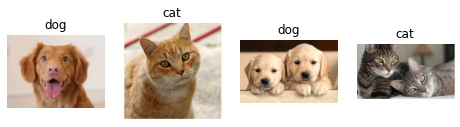

In [6]:
a = test_CNN_model(CNN_model, test_imgs_path, labels = ["cat","dog"])

In [7]:
def preprocess_img(img : np.ndarray , size = (128,128)):
    img = cv2.resize(img, size)
    img = img / 255
    img = np.expand_dims(img, axis = 0)
    return img


In [8]:
def extract_last_conv_layer(model):
    for layer in reversed(model.layers):
        if len(layer.output_shape) == 4:
            #print(layer.output_shape)
            return layer.name

In [9]:
def generate_heatmap(img : np.ndarray, model = None, activations_layer ='auto', 
                     class_id = 1 , cmap = cv2.COLORMAP_HOT):

    if activations_layer == 'auto':
        layer_name = extract_last_conv_layer(model)
        last_conv_layer = model.get_layer(layer_name)
    else:
        last_conv_layer = model.get_layer(activations_layer)

    grads_model = Model(inputs = [model.inputs], outputs = [last_conv_layer.output, model.output])
    #print(type(grads_model))
    with tf.GradientTape() as tape:
        img = tf.cast(img, tf.float32)
        last_conv_activations, preds = grads_model(img)

        #print(model.output_shape[1])

        if model.output_shape[1] == 1:
            grads = tape.gradient(preds , last_conv_activations)

        else :
            grads = tape.gradient(preds[:,class_id] , last_conv_activations)
    
    #print(type(grads))
    cast_grads = tf.cast(grads > 0 , tf.float32)
    cast_activations = tf.cast(last_conv_activations > 0 , tf.float32 )
    guided_grads = cast_grads * cast_activations * grads

    #print(guided_grads.shape)

    guided_grads = guided_grads[0]
    last_conv_activations = last_conv_activations[0]

    weights = tf.reduce_mean(guided_grads, axis = (0,1))

    heatmap = tf.multiply(last_conv_activations, weights )
    heatmap = tf.reduce_sum(heatmap , axis = -1)

    heatmap = heatmap - np.min(heatmap)
    heatmap = heatmap / (np.max(heatmap) - np.min(heatmap) + 1e-6)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap , (img.shape[2], img.shape[1]))
    heatmap = cv2.applyColorMap(heatmap, cmap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    #print((img.shape[1], img.shape[0]))
    #plt.imshow(heatmap)

    return heatmap




In [10]:
def overlay_heatmap(heatmap : np.ndarray , img: np.ndarray, alpha = 0.5 , beta = 0.7):
    heatmap = cv2.resize(heatmap, (img.shape[1],img.shape[0]))
    output = cv2.addWeighted(img, alpha , heatmap, beta, 0)
    #output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

    #plt.imshow(output)
    return output


In [11]:
for img_file in os.listdir(test_imgs_path):
    img = cv2.imread(os.path.join(test_imgs_path, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_processed = preprocess_img(img)
    heatmap = generate_heatmap(img_processed, model = CNN_model, activations_layer ='auto',cmap = cv2.COLORMAP_JET)
    overlayed = overlay_heatmap(heatmap , img, alpha = 0.5 , beta = 0.7)

    overlayed = cv2.cvtColor(overlayed , cv2.COLOR_BGR2RGB)
    heatmap = cv2.cvtColor(heatmap , cv2.COLOR_BGR2RGB)

    cv2.imwrite(os.path.join(results_path, f'{img_file[:-4]}_heatmap_only.png'), heatmap)
    cv2.imwrite(os.path.join(results_path, f'{img_file[:-4]}_heatmap_overlayed.png'), overlayed)
    



In [12]:
def video_heatmap_overlay(video_file , save_file, 
                        model, activations_layer ='auto',
                        preprocess_size = (128,128),
                        class_id = 10,
                        cmap = cv2.COLORMAP_JET,
                        alpha = 0.5 , beta = 0.7) :

    cap = cv2.VideoCapture(video_file)

    width  = int(cap.get(3) )  # get `width` 
    height = int(cap.get(4) )  # get `height` 

    # define an output VideoWriter  object
    out = cv2.VideoWriter(save_file,
                        cv2.VideoWriter_fourcc(*"MJPG"),
                        15,(width,height))

    # Check if the webcam is opened correctly
    if not cap.isOpened():
        print("Error opening video stream or file")


    # Read the video frames
    while cap.isOpened():
        ret, frame = cap.read()

        # If the frame was not read successfully, break the loop
        if not ret:
            print("Error reading frame")
            print((width,height),overlayed.shape)
            break

        # Capture the video frame
        # by frame
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_processed = preprocess_img(frame , size = preprocess_size)

        heatmap = generate_heatmap(frame_processed, model = model, class_id = class_id,
                                   activations_layer = activations_layer, cmap = cmap)
        overlayed = overlay_heatmap(heatmap , frame , alpha = alpha , beta = beta)

        overlayed = cv2.cvtColor(overlayed , cv2.COLOR_BGR2RGB)

        out.write(overlayed)
        
        # the 'q' button is set as the
        # quitting button you may use any
        # desired button of your choice

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # After the loop release the cap object
    cap.release()
    out.release()

In [13]:
for i , video_file in enumerate(os.listdir(test_vids_path)):

    save_file = os.path.join(results_path, f"{video_file[:3]}_{str(i+1)}_heatmap.avi")
    print(save_file)
    
    video_heatmap_overlay(video_file = os.path.join(test_vids_path, video_file) , 
                          save_file = save_file, 
                          model = CNN_model, activations_layer ='auto',
                          cmap = cv2.COLORMAP_JET,
                          alpha = 0.5 , beta = 0.7)


/content/results/cat_1_heatmap.avi
Error reading frame
(608, 1080) (1080, 608, 3)
/content/results/cat_2_heatmap.avi
Error reading frame
(360, 640) (640, 360, 3)
/content/results/dog_3_heatmap.avi
Error reading frame
(720, 1280) (1280, 720, 3)
/content/results/dog_4_heatmap.avi
Error reading frame
(608, 1080) (1080, 608, 3)


In [14]:
from tensorflow.keras.applications import mobilenet_v2

mnet_model = mobilenet_v2.MobileNetV2(input_shape = (128,128,3),
                                    include_top = True,
                                     weights = 'imagenet'
                                    )

14536120/14536120 [==============================] - 0s 0us/step


In [15]:
for i , video_file in enumerate(os.listdir(test_vids_path)):

    save_file = os.path.join(results_path, f"mnet_{video_file[:3]}_{str(i+1)}_heatmap.avi")
    print(save_file)
    if "cat" in video_file:
        class_id = 281 # tabby cat class
    elif "dog" in video_file:
        class_id = 235 # german shepherd class
    video_heatmap_overlay(video_file = os.path.join(test_vids_path, video_file) , 
                        save_file = save_file, 
                        model = mnet_model, activations_layer ='Conv_1',
                        class_id = class_id,
                        cmap = cv2.COLORMAP_JET,
                        alpha = 0.5 , beta = 0.7)

/content/results/mnet_cat_1_heatmap.avi
Error reading frame
(608, 1080) (1080, 608, 3)
/content/results/mnet_cat_2_heatmap.avi
Error reading frame
(360, 640) (640, 360, 3)
/content/results/mnet_dog_3_heatmap.avi
Error reading frame
(720, 1280) (1280, 720, 3)
/content/results/mnet_dog_4_heatmap.avi
Error reading frame
(608, 1080) (1080, 608, 3)


In [16]:
def GIF_from_vid(vid_file, gif_file, fps = 20, skip = 2):
    i = 0

    cap = cv2.VideoCapture(vid_file)
    width  = int(cap.get(3) )  # get `width` 
    height = int(cap.get(4) )  # get `height` 

    # Create a writer object to write the frames to a GIF file
    writer = imageio.get_writer(gif_file, mode='I',fps=fps)

    # Check if the webcam is opened correctly
    if not cap.isOpened():
        print("Error opening video stream or file")


    # Read the video frames
    while cap.isOpened():
        ret, frame = cap.read()

        # If the frame was not read successfully, break the loop
        if not ret:
            print("Error reading frame")
            break
        i+=1
        if( i % skip == 0):
            continue
        # add current frame to the GIF file
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        writer.append_data(frame)

    # Close the reader and writer objects
    writer.close()
    cap.release()


In [17]:
gifs_dir ='/content/gifs'
if not os.path.exists(gifs_dir):
    os.mkdir(gifs_dir)
    print(f"Directory '{gifs_dir}' created!")

Directory '/content/gifs' created!


In [18]:

for filename in os.listdir(results_path):
    if filename.endswith(".avi"):
        vid_file = os.path.join(results_path, filename)
        gif_file = os.path.join(gifs_dir,filename[:-4] + ".gif")
        GIF_from_vid(vid_file, gif_file, fps = 20, skip = 2)

Error reading frame
Error reading frame
Error reading frame
Error reading frame
Error reading frame
Error reading frame
Error reading frame
Error reading frame


In [19]:
!zip -r /content/gifs.zip /content/gifs

  adding: content/gifs/ (stored 0%)
  adding: content/gifs/cat_2_heatmap.gif (deflated 0%)
  adding: content/gifs/mnet_dog_4_heatmap.gif (deflated 0%)
  adding: content/gifs/mnet_cat_2_heatmap.gif (deflated 0%)
  adding: content/gifs/dog_4_heatmap.gif (deflated 0%)
  adding: content/gifs/dog_3_heatmap.gif (deflated 0%)
  adding: content/gifs/cat_1_heatmap.gif (deflated 0%)
  adding: content/gifs/mnet_cat_1_heatmap.gif (deflated 0%)
  adding: content/gifs/mnet_dog_3_heatmap.gif (deflated 0%)


In [20]:
!zip -r /content/results.zip /content/results

  adding: content/results/ (stored 0%)
  adding: content/results/dog_heatmap_overlayed.png (deflated 6%)
  adding: content/results/dog_4_heatmap.avi (deflated 1%)
  adding: content/results/mnet_cat_2_heatmap.avi (deflated 2%)
  adding: content/results/cat_1_heatmap.avi (deflated 1%)
  adding: content/results/2 cats_heatmap_only.png (deflated 50%)
  adding: content/results/cat_2_heatmap.avi (deflated 1%)
  adding: content/results/cat_heatmap_overlayed.png (deflated 1%)
  adding: content/results/2 dogs_heatmap_only.png (deflated 35%)
  adding: content/results/cat_heatmap_only.png (deflated 35%)
  adding: content/results/2 cats_heatmap_overlayed.png (deflated 2%)
  adding: content/results/mnet_dog_3_heatmap.avi (deflated 1%)
  adding: content/results/2 dogs_heatmap_overlayed.png (deflated 1%)
  adding: content/results/mnet_dog_4_heatmap.avi (deflated 2%)
  adding: content/results/mnet_cat_1_heatmap.avi (deflated 3%)
  adding: content/results/dog_heatmap_only.png (deflated 39%)
  adding: c